## Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2

import glob
import os

2022-02-04 17:05:29.670145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-04 17:05:29.670184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [30]:
import imutils
from imutils import face_utils

import dlib

# Data preparation

## Importing data

Testing and training sets are located in <code>./data</code> folder

In [3]:
train_mask = glob.glob('data/train/mask/*.jpg')
train_no_mask = glob.glob('data/train/no_mask/*.jpg')
test_mask = glob.glob('data/test/mask/*.jpg')
test_no_mask = glob.glob('data/test/no_mask/*.jpg')

## Spliting data into training, validation and testing sets

Shuffling both training and test sets

In [4]:
np.random.shuffle(train_mask)
np.random.shuffle(train_no_mask)

We also seperate out validation set from big training set, then prepare arrays with target classes

In [5]:
val_mask = train_mask[500:]
val_no_mask = train_mask[500:]

train_mask = train_mask[:500]
train_no_mask = train_no_mask[:500]

X_train = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in train_mask + train_no_mask])
y_train = np.array([label for label in ['mask'] * len(train_mask) + ['no_mask'] * len(train_no_mask)])

X_val = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in val_mask + val_no_mask])
y_val = np.array([label for label in ['mask'] * len(val_mask) + ['no_mask'] * len(val_no_mask)])

X_test = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in test_mask + test_no_mask])
y_test = np.array([label for label in ['mask'] * len(test_mask) + ['no_mask'] * len(test_no_mask)])

In [18]:
print('Set sizes: train: {}, val: {}, test: {}'.format(len(X_train), len(X_val), len(X_test)))

Set sizes: train: 1000, val: 308, test: 194


Example image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


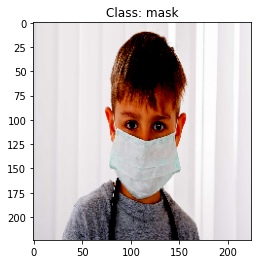

In [6]:
plt.imshow(X_train[77])
plt.title("Class: " + y_train[77])
plt.show()

## Preprocesing

We transform target class with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OneHotEncoder</a>

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

# Object detection model

## Defining image data generator

<a href='https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator'>ImageDataGenerator</a> will be usful for fetching moderately transformed images during model's learning process

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Defining model structure

We use predefined <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2'>Tensorflows's MobileNetV2</a> architecture as basis of our model

In [31]:
baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=(224, 224, 3)), weights=None)

**\<description\>**

In [32]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [33]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [34]:
INIT_LR = 1e-4 #initial learning rate
EPOCHS = 10 #number of epochs
BS = 8 # batch size

In [35]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [36]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Epoch 1/10
125/125 [==============================] - 78s 559ms/step - loss: 0.6932 - accuracy: 0.4890 - precision_1: 0.4899 - recall_1: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 2/10
125/125 [==============================] - 56s 443ms/step - loss: 0.6932 - accuracy: 0.4940 - precision_1: 0.4940 - recall_1: 0.4940
Epoch 3/10
 75/125 [=================>............] - ETA: 23s - loss: 0.6931 - accuracy: 0.5283 - precision_1: 0.5283 - recall_1: 0.5283

KeyboardInterrupt: 

In [19]:
model.save("mask_detector.model", save_format="h5")

/home/wojtek/anaconda3/envs/cv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=("mask","no_mask")))

              precision    recall  f1-score   support

        mask       1.00      0.99      0.99        97
     no_mask       0.99      1.00      0.99        97

    accuracy                           0.99       194
   macro avg       0.99      0.99      0.99       194
weighted avg       0.99      0.99      0.99       194



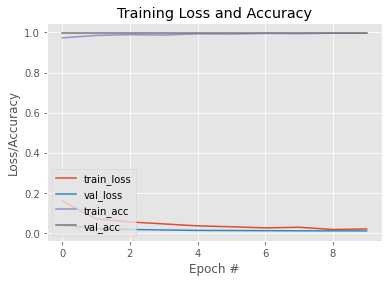

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [22]:
prototxtPath = os.path.sep.join(["deploy.prototxt.txt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])

In [23]:
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [24]:
model = load_model("mask_detector.model")

NameError: name 'load_model' is not defined

In [ ]:
image = cv2.imread("./data/train/no_mask/288.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

In [ ]:
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.90:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

In [ ]:
image = cv2.imread("./data/train/no_mask/288.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
image = cv2.imread('./data/face.jpg')
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detect faces in the grayscale image
rects = detector(gray, 1)

In [ ]:
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
shape

In [ ]:
coords = shape[[0, 8, 16]]
coords

In [ ]:
coords[2] - coords[0]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
diff = coords[2] - coords[0]

width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))

angle = np.degrees(np.arctan2(diff[1], diff[0]))

print(width, height, angle)

In [ ]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)
plt.imshow(s_img)

In [ ]:
img = s_img.copy()

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
img = np.delete(img, [rows], 0)
img = np.delete(img.transpose(1, 0, 2), [columns], 0)
img = img.transpose(1, 0, 2)
plt.imshow(img)

In [ ]:
l_img = cv2.imread("./data/train/no_mask/3.jpg")

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
gray = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
coords = shape[[0, 8, 16]]
diff = coords[2] - coords[0]
width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))
angle = np.degrees(np.arctan2(diff[1], diff[0]))

In [ ]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
s_img = np.delete(s_img, [rows], 0)
s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
s_img = s_img.transpose(1, 0, 2)

x_offset=shape[51][0] - int(s_img.shape[1]/2)
y_offset=shape[51][1] - int(s_img.shape[0]/2)

y1, y2 = y_offset, y_offset + s_img.shape[0]
x1, x2 = x_offset, x_offset + s_img.shape[1]

y1 = max(0, y1)
x1 = max(0, x1)
y2 = min(l_img.shape[0]-1, y2)
x2 = min(l_img.shape[1]-1, x2)

for y in range(y1, y2):
    for x in range(x1, x2):
        l_img[y, x] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y, x]
        
plt.imshow(l_img)

In [ ]:
l_img = cv2.imread('./data/face.jpg')

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
gray = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
coords = shape[[0, 8, 16]]
diff = coords[2] - coords[0]
width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))
angle = np.degrees(np.arctan2(diff[1], diff[0]))

In [ ]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
s_img = np.delete(s_img, [rows], 0)
s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
s_img = s_img.transpose(1, 0, 2)

x_offset=shape[51][0] - int(s_img.shape[1]/2)
y_offset=shape[51][1] - int(s_img.shape[0]/2)

y1, y2 = y_offset, y_offset + s_img.shape[0]
x1, x2 = x_offset, x_offset + s_img.shape[1]

y1 = max(0, y1)
x1 = max(0, x1)
y2 = min(l_img.shape[0]-1, y2)
x2 = min(l_img.shape[1]-1, x2)

for y in range(y1, y2):
    for x in range(x1, x2):
        l_img[y, x] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y, x]
        
plt.imshow(l_img)

In [ ]:
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        
    
# show the output image with the face detections + facial landmarks
cv2.imshow("Output", image)
cv2.waitKey(0)

In [ ]:
# compute the (x, y)-coordinates of the bounding box for the face
box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
(startX, startY, endX, endY) = box.astype("int")
# construct a dlib rectangle object from our bounding box coordinates
# and then determine the facial landmarks for the face region
rect = dlib.rectangle(int(startX), int(startY), int(endX), int(endY))
shape = predictor(image, rect)
shape = face_utils.shape_to_np(shape)
# grab the indexes of the facial landmarks for the left and right
# eye, respectively, then extract (x, y)-coordinates for each eye
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
leftEyePts = shape[lStart:lEnd]
rightEyePts = shape[rStart:rEnd]

# Bibliography

## Datasets

* https://data-flair.training/blogs/download-face-mask-data/
* https://www.kaggle.com/andrewmvd/face-mask-detection?select=annotations (for performence testing)